<a href="https://colab.research.google.com/github/rishabhvenkat/Pavlov_VS_IITM2/blob/main/Pavlov_VS_IITM2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Step 1: Import libraries
!pip install mne pandas
!pip install pymatreader
import mne
import numpy as np
import pandas as pd
from scipy import stats  # Import stats module for z-score calculation

In [2]:
import mne
import numpy as np

# Specify the path to the .set file
set_file = 'VegetativeState_44.set'

# Load the .SET file with preload set to True
try:
    eeg_data = mne.io.read_raw_eeglab(set_file, preload=True)
    print("Data loaded successfully!")

    # Check for NaN values and shape
    print("Data shape:", eeg_data.get_data().shape)
    print("Number of channels:", len(eeg_data.ch_names))
    print("NaN values:", np.isnan(eeg_data.get_data()).sum())

except OSError as e:
    print(f"Error loading .set file: {e}")
except RuntimeError as e:
    print(f"Runtime error: {e}")



Reading /content/VegetativeState_44.fdt
Reading 0 ... 22118399  =      0.000 ... 86399.996 secs...


<ipython-input-2-fede1aa40708>:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_data = mne.io.read_raw_eeglab(set_file, preload=True)


Data loaded successfully!
Data shape: (5, 22118400)
Number of channels: 5
NaN values: 0


In [3]:
# Step 2: Bandpass Filter
eeg_data.filter(l_freq=1., h_freq=40.)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)



<RawEEGLAB | VegetativeState_44.fdt, 5 x 22118400 (86400.0 s), ~843.8 MiB, data loaded>

In [4]:
# Select only EEG channels, excluding bad ones
picks = mne.pick_types(eeg_data.info, eeg=True, exclude='bads')
n_channels = len(picks)
n_components = min(20, n_channels)

Fitting ICA to data using 5 channels (please be patient, this may take a while)
Selecting by number: 5 components
Fitting ICA took 60.5s.
Creating RawArray with float64 data, n_channels=5, n_times=22118400
    Range : 0 ... 22118399 =      0.000 ... 86399.996 secs
Ready.
Using matplotlib as 2D backend.


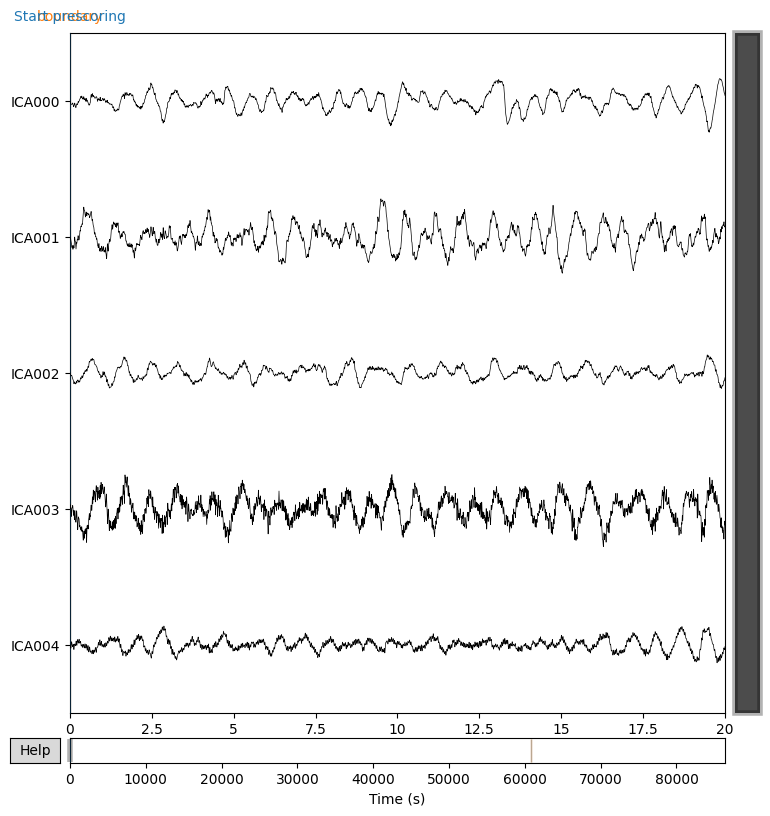

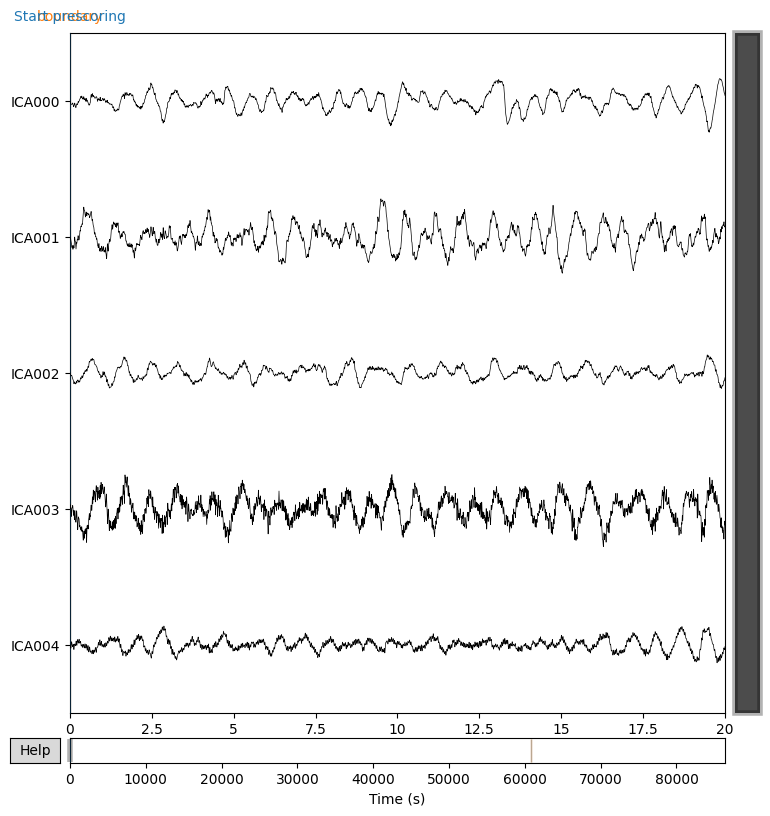

In [5]:
# Continue with ICA setup without montage
ica = mne.preprocessing.ICA(n_components=n_components, random_state=97)
ica.fit(eeg_data, picks=picks)

# Alternative visualization if montage is skipped
ica.plot_sources(eeg_data)  # Plot the time series of each component



In [6]:
# Set components to exclude based on visual inspection of the images
ica.exclude = [1, 3]

In [7]:
# Apply ICA if you have identified components
ica.apply(eeg_data)

Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 2 ICA components
    Projecting back using 5 PCA components


<RawEEGLAB | VegetativeState_44.fdt, 5 x 22118400 (86400.0 s), ~843.8 MiB, data loaded>

In [8]:
# Step 4: Non-overlapping 30-second epoching, starting from time=0
epoch_duration = 30  # 30 seconds
epochs = mne.make_fixed_length_epochs(eeg_data, duration=epoch_duration, preload=True)

Not setting metadata
2880 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 2880 events and 7680 original time points ...
0 bad epochs dropped


In [9]:
# Step 5: Convert epochs to a DataFrame and save each epoch
data = epochs.get_data()  # Shape: (n_epochs, n_channels, n_times)
n_epochs, n_channels, n_times = data.shape

In [10]:
# Initialize a list to store each epoch as a DataFrame
df_list = []

In [11]:
# Loop through each epoch and convert to DataFrame
for epoch_idx in range(n_epochs):
    epoch_data = data[epoch_idx, :, :]
    time_points = np.linspace(0, epoch_duration, n_times)  # Time points for each epoch
    epoch_df = pd.DataFrame(epoch_data.T, columns=[f'Channel_{i+1}' for i in range(n_channels)])
    epoch_df['Time'] = time_points
    epoch_df['Epoch'] = epoch_idx + 1  # Label each epoch for reference
    df_list.append(epoch_df)

In [12]:
# Concatenate all epochs into a single DataFrame
final_df = pd.concat(df_list, ignore_index=True)

In [13]:
# Save to CSV for future use
final_df.to_csv('epochs_data.csv', index=False)
print("Data saved to epochs_data.csv.")

Data saved to epochs_data.csv.


In [14]:
# ---- Load from CSV (for future use without reloading .set or .fdt files) ----
# Loading processed CSV data directly
df = pd.read_csv('epochs_data.csv')
print("Data loaded from epochs_data.csv.")

Data loaded from epochs_data.csv.


In [15]:
# Step 6: Removing outliers using z-score method on numerical data
df_cleaned = df[(np.abs(stats.zscore(df.select_dtypes(include=[np.number]))) < 3).all(axis=1)]

In [16]:
# Save cleaned data to CSV
df_cleaned.to_csv('cleaned_eeg_data.csv', index=False)
print("Outlier-free data saved to cleaned_eeg_data.csv.")

KeyboardInterrupt: 